## Ref

+ Dynamic Matrix Factorization with Priors on Unknown Values
+ https://arxiv.org/pdf/1507.06452.pdf

### imports

In [1]:
import numpy as np
import csv
import random
import time
import copy
import pickle

### Load data

In [5]:
train = []
update = []
test = []

with open("yelp_offline_train.csv", newline = "") as f:
    rows = csv.reader(f)
    for row in rows:
        if row[0] == "user_id":
            continue
        train.append(row)
        
with open("yelp_offline_test.csv", newline = "") as f:
    rows = csv.reader(f)
    for row in rows:
        if row[0] == "user_id":
            continue
        test.append(row)

In [6]:
train[:5]

[['0', '11768', '20100822'],
 ['0', '6106', '20101224'],
 ['0', '11414', '20110101'],
 ['0', '1756', '20110102'],
 ['0', '8027', '20110116']]

In [7]:
test[:5]

[['0', '4089', '20141204'],
 ['1', '1020', '20140913'],
 ['2', '21626', '20141013'],
 ['3', '18704', '20140403'],
 ['4', '6835', '20141003']]

In [8]:
user_dict = {}
item_dict = {}
user_count = 0
item_count = 0

for row in train:
    if row[0] not in user_dict:
        user_dict[row[0]] = user_count
        user_count += 1
    if row[1] not in item_dict:
        item_dict[row[1]] = item_count
        item_count += 1
        
for row in test:
    if row[0] not in user_dict:
        user_dict[row[0]] = user_count
        user_count += 1
    if row[1] not in item_dict:
        item_dict[row[1]] = item_count
        item_count += 1

In [9]:
user_dict_2 = {}
item_dict_2 = {}

for user in user_dict:
    user_dict_2[user_dict[user]] = user
for item in item_dict:
    item_dict_2[item_dict[item]] = item

In [10]:
for row in train:
    row[0] = user_dict[row[0]]
    row[1] = item_dict[row[1]]
    
for row in test:
    row[0] = user_dict[row[0]]
    row[1] = item_dict[row[1]]

In [11]:
train[:5]

[[0, 0, '20100822'],
 [0, 1, '20101224'],
 [0, 2, '20110101'],
 [0, 3, '20110102'],
 [0, 4, '20110116']]

In [12]:
test[:5]

[[0, 10915, '20141204'],
 [1, 1822, '20140913'],
 [2, 487, '20141013'],
 [3, 165, '20140403'],
 [4, 8761, '20141003']]

### data size

In [13]:
n_user = len(user_dict)
n_item = len(item_dict)
n_rating = len(train)

print("number of ratings:", n_rating)
print("n_user:", n_user)
print("n_item:", n_item)

number of ratings: 848494
n_user: 30407
n_item: 22676


### number of training and updating

In [14]:
n_train = len(train)
n_test = len(test)

print("n_train:", n_train)
print("n_test:", n_test)

n_train: 848494
n_test: 30407


### construct rating matrix

In [15]:
ratings = []
zeros = np.zeros(n_item)

for _ in range(n_user):
    ratings.append(zeros.copy())
    
for i in range(n_train):
    ratings[train[i][0]][train[i][1]] = 1.0

In [16]:
ratings[0][:10]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

### list rated movies for each user & for each movie

In [17]:
rate_lists_user = []
rate_lists_item = []

for i in range(n_user):
    tmp = []
    for j in range(n_item):
        if ratings[i][j] > 0.1:
            tmp.append(j)
    rate_lists_user.append(tmp.copy())
    
for i in range(n_item):
    tmp = []
    for j in range(n_user):
        if ratings[j][i] > 0.1:
            tmp.append(j)
    rate_lists_item.append(tmp.copy())

In [18]:
len(rate_lists_user[0])

45

In [19]:
len(rate_lists_item[0])

66

### initialize user and item vectors

In [20]:
user_vecs = []
item_vecs = []
dim = 100

def noise(dim):
    return np.random.uniform(-1, 1, dim)

for i in range(n_user):
    user_vecs.append(noise(dim))
for i in range(n_item):
    item_vecs.append(noise(dim))

In [21]:
user_vecs[0]

array([-0.51507744, -0.8739613 ,  0.07826759, -0.28924803,  0.03932313,
       -0.46884907,  0.21993249,  0.89380896,  0.7686533 , -0.78214208,
       -0.91201712,  0.39742737,  0.92409687, -0.18704837, -0.062727  ,
        0.7378758 ,  0.42991512,  0.55779159,  0.0117248 ,  0.08988632,
        0.77667358,  0.11764275,  0.40213369, -0.13836316, -0.93725085,
       -0.00127812,  0.29813913, -0.03369006,  0.52155239, -0.95667744,
        0.81450935, -0.34984538,  0.63130162,  0.4533578 , -0.330553  ,
       -0.24368469, -0.32380983,  0.83932235,  0.06022909,  0.85817951,
        0.88214116,  0.25771034,  0.84464748,  0.12378565,  0.83390623,
        0.73788482, -0.94082359, -0.67930205,  0.39680989, -0.15660266,
       -0.8701445 , -0.40896153, -0.76775843, -0.91895213,  0.89479709,
       -0.01573443, -0.66735573, -0.10603587, -0.76865649,  0.15929475,
        0.99964131,  0.90843384, -0.09944992, -0.78127591,  0.10790989,
       -0.93743137,  0.8968565 ,  0.69864633,  0.78633598,  0.03

### calculate $S^{user}$ and $S^{item}$

In [22]:
def vec_mul(arr):
    l = len(arr)
    ret = []
    
    for i in range(l):
        tmp = np.zeros(l)
        for j in range(l):
            tmp[j] = arr[i] * arr[j]
        ret.append(tmp)
        
    return ret

In [23]:
def update_s_user():
    for i in range(n_user):
        s = vec_mul(user_vecs[i])
        for j in range(dim):
            s_user[j] += s[j]

def update_s_item():
    for i in range(n_item):
        s = vec_mul(item_vecs[i])
        for j in range(dim):
            s_item[j] += s[j]

### gradient of loss

In [24]:
def dot(a, b):
    ret = 0.0
    for i in range(len(a)):
        ret += a[i] * b[i]
    return ret

def sign(x):
    if x >= 0:
        return 1
    else:
        return -1

def gradient_user(i, alpha, lmd):
    ret = np.zeros(dim)
    # 2 * \alpha * w_i * S^h
    for j in range(dim):
        ret[j] += 2 * alpha * dot(user_vecs[i], s_item[j])
    # \lambda * sign(w_i)
    for j in range(dim):
        ret[j] += lmd * sign(user_vecs[i][j])
    # -2 * \sum{h_j}
    for j in range(len(rate_lists_user[i])):
        no = rate_lists_user[i][j]
        rate = ratings[i][no]
        scalar = rate - (1-alpha) * dot(user_vecs[i], item_vecs[no])
        scalar *= -2
        ret += scalar * item_vecs[no]
    return ret

def gradient_item(i, alpha, lmd):
    ret = np.zeros(dim)
    # 2 * \alpha * h_i * S^w
    for j in range(dim):
        ret[j] += 2 * alpha * dot(item_vecs[i], s_user[j])
    # \lambda * sign(h_i)
    for j in range(dim):
        ret[j] += lmd * sign(item_vecs[i][j])
    # -2 * \sum{w_j}
    for j in range(len(rate_lists_item[i])):
        no = rate_lists_item[i][j]
        rate = ratings[no][i]
        scalar = rate - (1-alpha) * dot(item_vecs[i], user_vecs[no])
        scalar *= -2
        ret += scalar * user_vecs[no]
    return ret

def gradient_user_u(i, alpha, lmd):
    ret = np.zeros(dim)
    # 2 * \alpha * w_i * S^h
    for j in range(dim):
        ret[j] += 2 * alpha * dot(user_vecs_u[i], s_item_u[j])
    # \lambda * sign(w_i)
    for j in range(dim):
        ret[j] += lmd * sign(user_vecs_u[i][j])
    # -2 * \sum{h_j}
    for j in range(len(rate_lists_user_u[i])):
        no = rate_lists_user_u[i][j]
        rate = ratings_u[i][no]
        scalar = rate - (1-alpha) * dot(user_vecs_u[i], item_vecs_u[no])
        scalar *= -2
        ret += scalar * item_vecs_u[no]
    return ret

def gradient_item_u(i, alpha, lmd):
    ret = np.zeros(dim)
    # 2 * \alpha * h_i * S^w
    for j in range(dim):
        ret[j] += 2 * alpha * dot(item_vecs_u[i], s_user_u[j])
    # \lambda * sign(h_i)
    for j in range(dim):
        ret[j] += lmd * sign(item_vecs_u[i][j])
    # -2 * \sum{w_j}
    for j in range(len(rate_lists_item_u[i])):
        no = rate_lists_item_u[i][j]
        rate = ratings_u[no][i]
        scalar = rate - (1-alpha) * dot(item_vecs_u[i], user_vecs_u[no])
        scalar *= -2
        ret += scalar * user_vecs_u[no]
    return ret

### hyperparameters

In [31]:
lmd = 0.01
alpha = 0.0025
rho = alpha * (n_user*n_item - n_train) / n_train
EPOCH = 50
lr = 0.001 # the paper use line search, but setting learning rate is good enough

print("lambda:", lmd)
print("alpha:", alpha)
print("rho:", rho)
print("learning rate:", lr)

lambda: 0.01
alpha: 0.0025
rho: 2.0290674948791625
learning rate: 0.001


### train

In [32]:
def update_user(i, scalar):
    mat = vec_mul(user_vecs[i])
    for j in range(dim):
        s_user[j] += scalar * mat[j]
    return

def update_item(i, scalar):
    mat = vec_mul(item_vecs[i])
    for j in range(dim):
        s_item[j] += scalar * mat[j]
    return

def update_user_u(i, scalar):
    mat = vec_mul(user_vecs_u[i])
    for j in range(dim):
        s_user_u[j] += scalar * mat[j]
    return

def update_item_u(i, scalar):
    mat = vec_mul(item_vecs_u[i])
    for j in range(dim):
        s_item_u[j] += scalar * mat[j]
    return

In [33]:
def cal_loss():
    ret = 0.0
    for i in range(n_user):
        for j in range(n_item):
            if ratings[i][j] > 0.1:
                residual = ratings[i][j] - dot(user_vecs[i], item_vecs[j])
                ret += residual ** 2
            else:
                residual = ratings[i][j] - dot(user_vecs[i], item_vecs[j])
                ret += alpha * (residual ** 2)
    sum_w = 0.0
    for i in range(n_user):
        for j in range(dim):
            sum_w += sign(user_vecs[i][j]) * user_vecs[i][j]
    for i in range(n_item):
        for j in range(dim):
            sum_w += sign(item_vecs[i][j]) * item_vecs[i][j]
    return ret + lmd * sum_w

def cal_loss_u():
    ret = 0.0
    for i in range(n_user):
        for j in range(n_item):
            if ratings_u[i][j] > 0.1:
                residual = ratings_u[i][j] - dot(user_vecs_u[i], item_vecs_u[j])
                ret += residual ** 2
            else:
                residual = ratings_u[i][j] - dot(user_vecs_u[i], item_vecs_u[j])
                ret += alpha * (residual ** 2)
    sum_w = 0.0
    for i in range(n_user):
        for j in range(dim):
            sum_w += sign(user_vecs_u[i][j]) * user_vecs_u[i][j]
    for i in range(n_item):
        for j in range(dim):
            sum_w += sign(item_vecs_u[i][j]) * item_vecs_u[i][j]
    return ret + lmd * sum_w

In [34]:
def cal_acc(n):
    predict = []
    rates = []
    error = 0.0

    for i in range(n):
        rates.append(1.0)
        predict.append(dot(user_vecs[test[i][0]], item_vecs[test[i][1]]))

    for i in range(n):
        error += abs(rates[i] - predict[i])

    return error / n

def cal_acc_u(n):
    predict = []
    rates = []
    error = 0.0

    for i in range(n):
        rates.append(1.0)
        predict.append(dot(user_vecs_u[test[i][0]], item_vecs_u[test[i][1]]))

    for i in range(n):
        error += abs(rates[i] - predict[i])

    return error / n

def cal_insample_acc(n):
    predict = []
    rates = []
    error = 0.0

    for i in range(n):
        rates.append(1.0)
        predict.append(dot(user_vecs[train[i][0]], item_vecs[train[i][1]]))

    for i in range(n):
        error += abs(rates[i] - predict[i])

    return error / n

def cal_insample_acc_u(n):
    predict = []
    rates = []
    error = 0.0

    for i in range(n):
        rates.append(1.0)
        predict.append(dot(user_vecs_u[train[i][0]], item_vecs_u[train[i][1]]))

    for i in range(n):
        error += abs(rates[i] - predict[i])

    return error / n

In [35]:
user_vecs = []
item_vecs = []
s_user = vec_mul(np.zeros(dim))
s_item = vec_mul(np.zeros(dim))

for i in range(n_user):
    user_vecs.append(noise(dim))
for i in range(n_item):
    item_vecs.append(noise(dim))

update_s_user()
update_s_item()

user_vecs_u = copy.deepcopy(user_vecs)
item_vecs_u = copy.deepcopy(item_vecs)
s_user_u = copy.deepcopy(s_user)
s_item_u = copy.deepcopy(s_item)

In [36]:
user_vecs = copy.deepcopy(user_vecs_u)
item_vecs = copy.deepcopy(item_vecs_u)
s_user = copy.deepcopy(s_user_u)
s_item = copy.deepcopy(s_item_u)

start_train_time = time.time()
cal_loss_time = 0.0
cal_acc_time = 0.0

losses = []
in_accs = []
out_accs = []

In [ ]:
for epoch in range(EPOCH):
    lis_user = list(range(n_user))
    lis_item = list(range(n_item))
    random.shuffle(lis_user)
    random.shuffle(lis_item)
    count = 0
    
    for i in lis_user:
        grad = gradient_user(i, alpha, lmd)
        update_user(i, -1)
        user_vecs[i] -= lr * grad
        update_user(i, 1)
        
        if count % 100 == 99:
            print("user:", count+1, "; in-sample error:", cal_insample_acc(n_test), "; out-sample error", cal_acc(n_test))
        count += 1
    
    count = 0
    
    for i in lis_item:
        grad = gradient_item(i, alpha, lmd)
        update_item(i, -1)
        item_vecs[i] -= lr * grad
        update_item(i, 1)
        
        if count % 100 == 99:
            print("item:", count+1, "; in-sample error:", cal_insample_acc(n_test), "; out-sample error", cal_acc(n_test))
        count += 1
    
    loss_time = time.time()
    # loss = 0
    # loss = cal_loss()
    # losses.append(loss)
    cal_loss_time += time.time() - loss_time
    
    acc_time = time.time()
    in_acc = cal_insample_acc(n_test)
    out_acc = cal_acc(n_test)
    in_accs.append(in_acc)
    out_accs.append(out_acc)
    cal_acc_time += time.time() - acc_time
    
    print("\nepoch", epoch, ": averge error(in):", in_acc, "; averge error(out):", out_acc, "\n")

print("total training time:", time.time()-start_train_time)
print("cal loss time:", cal_loss_time)
print("cal accuracy time:", cal_acc_time)

user: 100 ; in-sample error: 2.76039083837 ; out-sample error 2.76364197604
user: 200 ; in-sample error: 2.75955953779 ; out-sample error 2.76315280955
user: 300 ; in-sample error: 2.75900286672 ; out-sample error 2.76247713871
user: 400 ; in-sample error: 2.75806825098 ; out-sample error 2.76188620775
user: 500 ; in-sample error: 2.75625908913 ; out-sample error 2.76113598819
user: 600 ; in-sample error: 2.75548840484 ; out-sample error 2.76054778846
user: 700 ; in-sample error: 2.75525373837 ; out-sample error 2.75988815115
user: 800 ; in-sample error: 2.7546157574 ; out-sample error 2.75929288351
user: 900 ; in-sample error: 2.75250216391 ; out-sample error 2.75863585287
user: 1000 ; in-sample error: 2.74761573871 ; out-sample error 2.75804686122
user: 1100 ; in-sample error: 2.7452150174 ; out-sample error 2.75729929065
user: 1200 ; in-sample error: 2.74449066037 ; out-sample error 2.75655489074
user: 1300 ; in-sample error: 2.74380951127 ; out-sample error 2.75604754376
user: 1400

user: 10800 ; in-sample error: 2.58450581956 ; out-sample error 2.69398480083
user: 10900 ; in-sample error: 2.58293032169 ; out-sample error 2.69332926838
user: 11000 ; in-sample error: 2.58219773913 ; out-sample error 2.69279699539
user: 11100 ; in-sample error: 2.58163360688 ; out-sample error 2.69207169407
user: 11200 ; in-sample error: 2.58060581138 ; out-sample error 2.69143487834
user: 11300 ; in-sample error: 2.57905990545 ; out-sample error 2.6907010109
user: 11400 ; in-sample error: 2.57854078683 ; out-sample error 2.68999674383
user: 11500 ; in-sample error: 2.578231317 ; out-sample error 2.68928080691
user: 11600 ; in-sample error: 2.57134121968 ; out-sample error 2.68873591689
user: 11700 ; in-sample error: 2.57093391474 ; out-sample error 2.68803027833
user: 11800 ; in-sample error: 2.57093391474 ; out-sample error 2.68734687361
user: 11900 ; in-sample error: 2.56924222065 ; out-sample error 2.68658784126
user: 12000 ; in-sample error: 2.56912884281 ; out-sample error 2.6

user: 21400 ; in-sample error: 2.45202235805 ; out-sample error 2.62239376142
user: 21500 ; in-sample error: 2.44907703775 ; out-sample error 2.62162939233
user: 21600 ; in-sample error: 2.44897809981 ; out-sample error 2.62070642467
user: 21700 ; in-sample error: 2.4487937069 ; out-sample error 2.62016915728
user: 21800 ; in-sample error: 2.44845386418 ; out-sample error 2.61951997274
user: 21900 ; in-sample error: 2.44486614212 ; out-sample error 2.6188521998
user: 22000 ; in-sample error: 2.44440198937 ; out-sample error 2.61830896721
user: 22100 ; in-sample error: 2.43862754578 ; out-sample error 2.61761663237
user: 22200 ; in-sample error: 2.43060400525 ; out-sample error 2.61683028008
user: 22300 ; in-sample error: 2.43041534516 ; out-sample error 2.61610120179
user: 22400 ; in-sample error: 2.42913282576 ; out-sample error 2.61542187014
user: 22500 ; in-sample error: 2.42817793196 ; out-sample error 2.61483729662
user: 22600 ; in-sample error: 2.42773080155 ; out-sample error 2.

item: 1600 ; in-sample error: 2.30204553469 ; out-sample error 2.53881760557
item: 1700 ; in-sample error: 2.30110888037 ; out-sample error 2.53798752348
item: 1800 ; in-sample error: 2.29953994515 ; out-sample error 2.53671886022
item: 1900 ; in-sample error: 2.2989157143 ; out-sample error 2.53620730085
item: 2000 ; in-sample error: 2.29784412119 ; out-sample error 2.5352636252
item: 2100 ; in-sample error: 2.29641490015 ; out-sample error 2.5342802604
item: 2200 ; in-sample error: 2.2950547455 ; out-sample error 2.53304226708
item: 2300 ; in-sample error: 2.29405752782 ; out-sample error 2.53205755686
item: 2400 ; in-sample error: 2.29285510474 ; out-sample error 2.5314045671
item: 2500 ; in-sample error: 2.29040109487 ; out-sample error 2.52950726459
item: 2600 ; in-sample error: 2.28887450885 ; out-sample error 2.52853409299
item: 2700 ; in-sample error: 2.28765119574 ; out-sample error 2.52720095851
item: 2800 ; in-sample error: 2.28626192176 ; out-sample error 2.52615899914
item

### test performance (out-sample)

In [ ]:
predict = []
rates = []

for i in range(n_test):
    rates.append(1.0)
    predict.append(dot(user_vecs[test[i][0]], item_vecs[test[i][1]]))

In [ ]:
for i in range(30):
    print("ans:", rates[i], "; predict:", predict[i])

In [ ]:
error = 0.0

for i in range(n_test):
    error += abs(rates[i] - predict[i])**2
    
print("averge error:", error / n_test)

In [ ]:
rating_list = [] # rating list for each user in training and updating data

for _ in range(n_user):
    rating_list.append([])

for row in train:
    rating_list[row[0]].append(row[1])

In [ ]:
not_rating_list = [] # rating list for each user not rating yet

for i in range(n_user):
    not_rating_list.append([])
    for j in range(n_item):
        if j not in rating_list[i]:
            not_rating_list[i].append(j)

In [ ]:
def take_value(elem):
    return elem[1]

top_n = []

for i in range(n_user):
    tmp = []
    for j in not_rating_list[i]:
        tmp.append([item_dict_2[j], dot(user_vecs[i], item_vecs[j])])
    tmp.sort(key = take_value)
    top_n.append(tmp[:100])

In [ ]:
with open("predict_offline.csv", "w", newline = "") as f:
    w = csv.writer(f)
    
    for i in range(n_user):
        row = []
        row.append(user_dict_2[i])
        for item in top_n[i]:
            row.append(item[0])
        w.writerow(row)

### test performance (in-sample)

In [43]:
predict = []
rates = []

for i in range(n_train):
    rates.append(1.0)
    predict.append(dot(user_vecs[train[i][0]], item_vecs[train[i][1]]))

In [44]:
for i in range(30):
    print("ans:", rates[i], "; predict:", predict[i])

ans: 1.0 ; predict: 0.5523556968748948
ans: 1.0 ; predict: 0.749103464834057
ans: 1.0 ; predict: 0.5649398089746898
ans: 1.0 ; predict: 0.775303885527917
ans: 1.0 ; predict: 0.34567286923268453
ans: 1.0 ; predict: 0.30218174439522916
ans: 1.0 ; predict: 0.38120942807761193
ans: 1.0 ; predict: 0.21369758870033392
ans: 1.0 ; predict: 0.4219488347352153
ans: 1.0 ; predict: 0.7294240961456246
ans: 1.0 ; predict: 0.42000137304405133
ans: 1.0 ; predict: 0.5453750622201439
ans: 1.0 ; predict: 0.4832363495896579
ans: 1.0 ; predict: 0.5398958290415744
ans: 1.0 ; predict: 0.6398563254804356
ans: 1.0 ; predict: 0.3370545480941776
ans: 1.0 ; predict: 0.7017265134612004
ans: 1.0 ; predict: 0.6524525456189196
ans: 1.0 ; predict: 0.6526618537152536
ans: 1.0 ; predict: 0.4555582244692692
ans: 1.0 ; predict: 0.583931460216683
ans: 1.0 ; predict: 0.45311413546391627
ans: 1.0 ; predict: 0.42726126844832596
ans: 1.0 ; predict: 0.4064266406365496
ans: 1.0 ; predict: 0.24745205171367918
ans: 1.0 ; predict: 

In [45]:
error = 0.0

for i in range(n_train):
    error += abs(rates[i] - predict[i])**2
    
print("averge error:", error / n_train)

averge error: 0.40141935283181496


### plot

In [46]:
import matplotlib.pyplot as plt

In [ ]:
# plt.plot(losses)
# plt.xlabel("epoch")
# plt.ylabel("loss")
# plt.show()

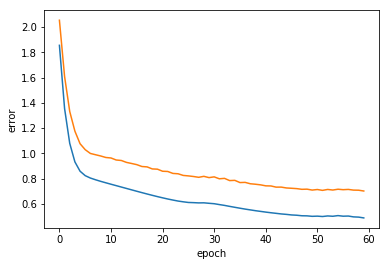

In [47]:
plt.plot(in_accs)
plt.plot(out_accs)
plt.xlabel("epoch")
plt.ylabel("error")
plt.show()